In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Homework #2 - SVM classifier 
- Andrey Novichkov
- DS 2.1
- April 15, 2020

In [2]:
dataset = load_breast_cancer()

dataset.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
feature_df = pd.DataFrame(data=dataset['data'])
target = data=dataset['target']

### Build Clustered Correlation Map

In [4]:
sns.set(rc={'figure.figsize':(30,20)})

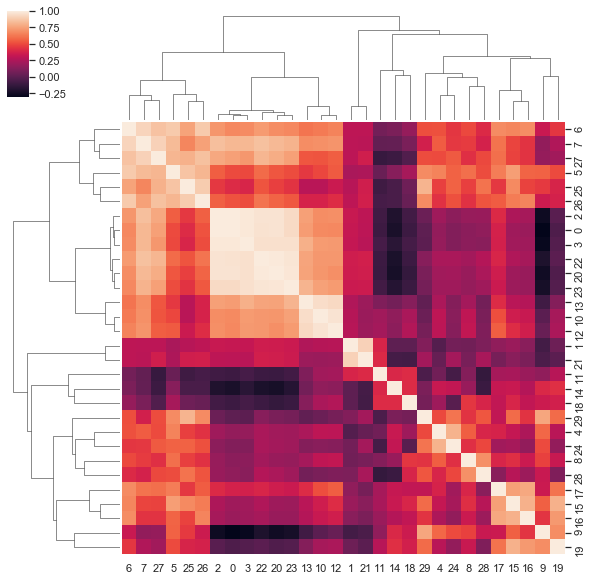

In [5]:
_= sns.clustermap(feature_df.corr(), annot=False, xticklabels=feature_df.columns, yticklabels=feature_df.columns)

### Let's do our initial analysis without removing any correlated features, and then refer back to this heatmap and try removing some features to see how that affects accuracy

# 1. Scaling our data
Going to use Standard Scaler from sklearn

In [6]:
from sklearn import preprocessing

ss = preprocessing.StandardScaler()

X = ss.fit_transform(feature_df)
y = target

# 2. Split Data into Test and Train
Going to use sklearn again

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# 3. Create and train classification model with linear kernel
Going to use sklearns Support Vector Machine(SVM) package

In [8]:
from sklearn import svm

svm_classifier = svm.SVC(kernel='linear', C=10)
_= svm_classifier.fit(X_train, y_train)

# 4. Make predictions using the model

In [9]:
y_pred = svm_classifier.predict(X_test)

# 5. Analize accuracy, recall and f1 score of the model
Going to utilize sklearns package again

In [10]:
from sklearn.model_selection import cross_val_score 

accuracies = cross_val_score(estimator=svm_classifier, X=X, y=y, cv=5, scoring='accuracy')
accuracy_mean = accuracies.mean()

print(f'All accuracies:\t{accuracies}')
print(f'Accuracy mean:\t{accuracy_mean}')

All accuracies:	[0.95652174 0.95652174 0.96460177 0.96460177 0.99115044]
Accuracy mean:	0.9666794921123509


In [11]:
f1_scores = cross_val_score(estimator=svm_classifier, X=X, y=y, cv=5, scoring='f1')
f1_score_mean = f1_scores.mean()

print(f'All f1_scores:\t {f1_scores}')
print(f'F1_score mean:\t {f1_score_mean}')

All f1_scores:	 [0.96503497 0.96503497 0.97260274 0.97183099 0.9929078 ]
F1_score mean:	 0.973482291425978


That's a pretty good accuracy and f1_score!

# 6. Let's do the same analysis but with our own scripts on the predicted data

In [12]:
def generate_confusion_matrix(actual_list, predicted_list):
    out = [[0., 0.],[0., 0.]]
    # Predicted     0   1
    # Actual:    0 TN  FP
    # Actual:    1 FN  TP 

    assert(len(actual_list) == len(predicted_list))
    
    for actual,predicted in zip(actual_list, predicted_list):
        # True Negatives/positives
        if actual == predicted: # True {something}
            if actual == 0: # True Negatices
                out[0][0] += 1
            else: # True Positives
                out[1][1] += 1
        else: # False {something}
            if predicted == 1: # False Positives
                out[0][1] += 1
            else: # False negatives
                out[1][0] += 1
    
    return pd.DataFrame(data=out, columns=[0, 1], index=[0, 1])

def get_accuracy(confusion_matrix):
    # TP + TN
    total = confusion_matrix.sum().sum()
    tp_plus_tn = confusion_matrix[1][1] + confusion_matrix[0][0]
    return tp_plus_tn/total

def get_error(confusion_matrix):
    # FP + FN
    total = confusion_matrix.sum().sum()
    fp_plus_fn = confusion_matrix[0][1] + confusion_matrix[1][0]
    return fp_plus_fn/total

def get_recall(confusion_matrix):
    # TP / (TP + FN)
    tp_plus_tn = confusion_matrix[1][1] + confusion_matrix[0][1]
    tp = confusion_matrix[1][1]
    return tp/tp_plus_tn

def get_specificity(confusion_matrix):
    # TN / (TN + FN)
    tn_plus_fn = confusion_matrix[0][0] + confusion_matrix[0][1]
    tn = confusion_matrix[0][0]
    return tn/tn_plus_fn

def get_precision(confusion_matrix):
    # TP / (TP + FP)
    tp_plus_fp = confusion_matrix[1][1] + confusion_matrix[1][0]
    tp = confusion_matrix[1][1]
    return tp/tp_plus_fp

def get_f1_score(confusion_matrix):
    numerator = 2*get_precision(confusion_matrix) * get_recall(confusion_matrix)
    denominator = get_precision(confusion_matrix) + get_recall(confusion_matrix)
    return numerator/denominator

In [13]:
c_matrix = generate_confusion_matrix(y_test, y_pred)
print(f'Accuracy: {get_accuracy(c_matrix)}')
print(f'Error: {get_error(c_matrix)}')
print(f'Recall: {get_recall(c_matrix)}')
print(f'Speceficity: {get_specificity(c_matrix)}')
print(f'Precision: {get_precision(c_matrix)}')
print(f'F1_score: {get_f1_score(c_matrix)}')

Accuracy: 0.956140350877193
Error: 0.043859649122807015
Recall: 0.9552238805970149
Speceficity: 0.9375
Precision: 0.9696969696969697
F1_score: 0.9624060150375939


Got a very similar result! 

# 7. Let's play around with SVM parameters to try to improve the model
Can mess with the C value and the kernels
- We can use GridSearch to find the optimal values

In [14]:
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

svc_param_selection(X, y, 5)

{'C': 0.1, 'gamma': 0.001}

Let's try those parameters

In [81]:
svm_classifier = svm.SVC(kernel='linear', C=.1)
_= svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracies = cross_val_score(estimator=svm_classifier, X=X, y=y, cv=5, scoring='accuracy')
accuracy_mean = accuracies.mean()

print(f'All accuracies:\t{accuracies}')
print(f'Accuracy mean:\t{accuracy_mean}')

f1_scores = cross_val_score(estimator=svm_classifier, X=X, y=y, cv=5, scoring='f1')
f1_score_mean = f1_scores.mean()

print(f'All f1_scores:\t {f1_scores}')
print(f'F1_score mean:\t {f1_score_mean}')

All accuracies:	[0.97391304 0.97391304 0.98230088 0.96460177 0.98230088]
Accuracy mean:	0.975405925355906
All f1_scores:	 [0.97931034 0.97959184 0.98611111 0.97222222 0.98591549]
F1_score mean:	 0.980630201570672


### So we managed to improve the f1 score to .98 from .97! Nice :)